In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import os

strategy = tf.distribute.MirroredStrategy()

print("Number of accelerators: ", strategy.num_replicas_in_sync)

2022-05-03 10:21:49.504146: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-03 10:21:50.215360: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30970 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of accelerators:  1


In [2]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1./255,
                                   validation_split=0.2)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
real = "./data/real_and_fake_face_detection/real_and_fake_face/training_real/"
fake = "./data/real_and_fake_face_detection/real_and_fake_face/training_fake/"
dataset = "./data/real_and_fake_face_detection/real_and_fake_face"

real_path = os.listdir(real)
fake_path = os.listdir(fake)
dataset_path = os.path.join(dataset)

train_generator1 = train_datagen.flow_from_directory(dataset_path,
                                                     batch_size=32,
                                                     target_size=(96, 96),
                                                     class_mode='binary',
                                                     subset="training")

Found 1633 images belonging to 2 classes.


In [4]:
val_generator = train_datagen.flow_from_directory(dataset_path,
                                                batch_size=32,
                                                target_size=(96, 96),
                                                class_mode='binary',
                                                subset="validation")

Found 408 images belonging to 2 classes.


In [5]:
train_generator1.labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [6]:
transfer1 = tf.keras.applications.DenseNet121(
  weights='imagenet',
  input_shape=(96, 96, 3),
  include_top=False
)

transfer2 = tf.keras.applications.ResNet101(
  weights='imagenet',
  input_shape=(96, 96, 3),
  include_top=False
)

transfer3 = tf.keras.applications.MobileNetV2(
  weights='imagenet',
  input_shape=(96, 96, 3),
  include_top=False
)

model1 = Sequential([
  transfer1,
  GlobalAveragePooling2D(),
  Dense(192, activation='relu'),
  BatchNormalization(),
  Dropout(0.5),
  Dense(2, activation='softmax')
])

model2 = Sequential([
  transfer2,
  GlobalAveragePooling2D(),
  Dense(192, activation='relu'),
  BatchNormalization(),
  Dropout(0.5),
  Dense(2, activation='softmax')
])

model3 = Sequential([
  transfer3,
  GlobalAveragePooling2D(),
  Dense(192, activation='relu'),
  BatchNormalization(),
  Dropout(0.5),
  Dense(2, activation='softmax')
])

model4 = Sequential([
  Conv2D(48, kernel_size=(3, 3), activation='relu', input_shape=(96, 96, 3)),
  BatchNormalization(),
  Conv2D(24, kernel_size=(3, 3), activation='relu'),
  BatchNormalization(),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Conv2D(48, kernel_size=(3, 3), activation='relu'),
  BatchNormalization(),
  MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.25),
  Flatten(),
  Dense(96, activation='relu'),
  BatchNormalization(),
  Dropout(0.25),
  Dense(2, activation='softmax')
])

models = [model1, model2, model3, model4]
model_input = tf.keras.layers.Input(shape=(96, 96, 3))
model_outputs = [model(model_input) for model in models]
ensemble_op = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_op)

ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 2)            7235458     input_4[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2)            43052738    input_4[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 2)            2505090     input_4[0][0]                    
______________________________________________________________________________________________

In [7]:
ensemble_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

In [8]:
def schedular(epoch):
  if epoch <= 2:
    return 0.001
  elif epoch > 2 and epoch <= 15:
    return 0.0001
  else:
    return 0.00001
  
lr_callbacks = tf.keras.callbacks.LearningRateScheduler(schedular)

In [9]:
hist = ensemble_model.fit(train_generator1, steps_per_epoch=1633//32, validation_steps=408//32, epochs=20, callbacks=[lr_callbacks], validation_data=val_generator)

2022-05-03 10:22:15.497473: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-05-03 10:22:37.596243: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


51/51 [==============================] - 47s 420ms/step - loss: 0.7334 - accuracy: 0.5740 - val_loss: 0.7482 - val_accuracy: 0.5182
Epoch 2/20
51/51 [==============================] - 16s 317ms/step - loss: 0.6392 - accuracy: 0.6377 - val_loss: 2.9304 - val_accuracy: 0.5260
Epoch 3/20
51/51 [==============================] - 16s 318ms/step - loss: 0.6185 - accuracy: 0.6571 - val_loss: 1.5025 - val_accuracy: 0.5156
Epoch 4/20
51/51 [==============================] - 16s 318ms/step - loss: 0.5594 - accuracy: 0.7227 - val_loss: 0.7481 - val_accuracy: 0.5260
Epoch 5/20
51/51 [==============================] - 16s 318ms/step - loss: 0.5290 - accuracy: 0.7439 - val_loss: 0.7934 - val_accuracy: 0.5000
Epoch 6/20
51/51 [==============================] - 16s 315ms/step - loss: 0.5184 - accuracy: 0.7489 - val_loss: 0.8117 - val_accuracy: 0.5260
Epoch 7/20
51/51 [==============================] - 16s 320ms/step - loss: 0.4829 - accuracy: 0.7733 - val_loss: 0.7980 - val_accuracy: 0.5156
Epoch 8/20

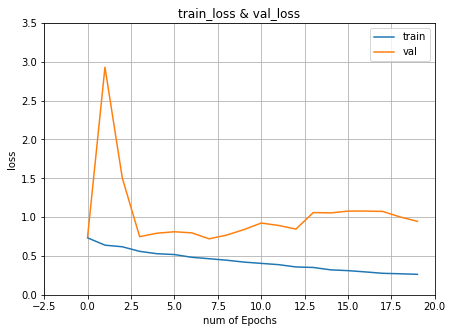

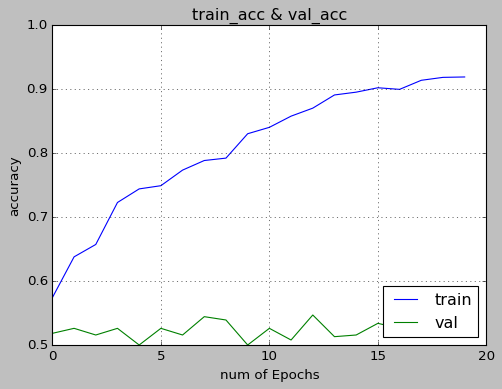

In [10]:
epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1, figsize=(7, 5))
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss & val_loss')
plt.grid(True)
plt.legend(['train', 'val'])
plt.style.use('classic')

plt.figure(2, figsize=(7, 5))
plt.plot(xc, train_acc)
plt.plot(xc, val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc & val_acc')
plt.grid(True)
plt.legend(['train','val'], loc=4)
plt.style.use(['classic'])

In [13]:
predictions = ensemble_model.predict_generator(val_generator)

/home/c4nd0it/anaconda3/envs/keras_env/lib/python3.8/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


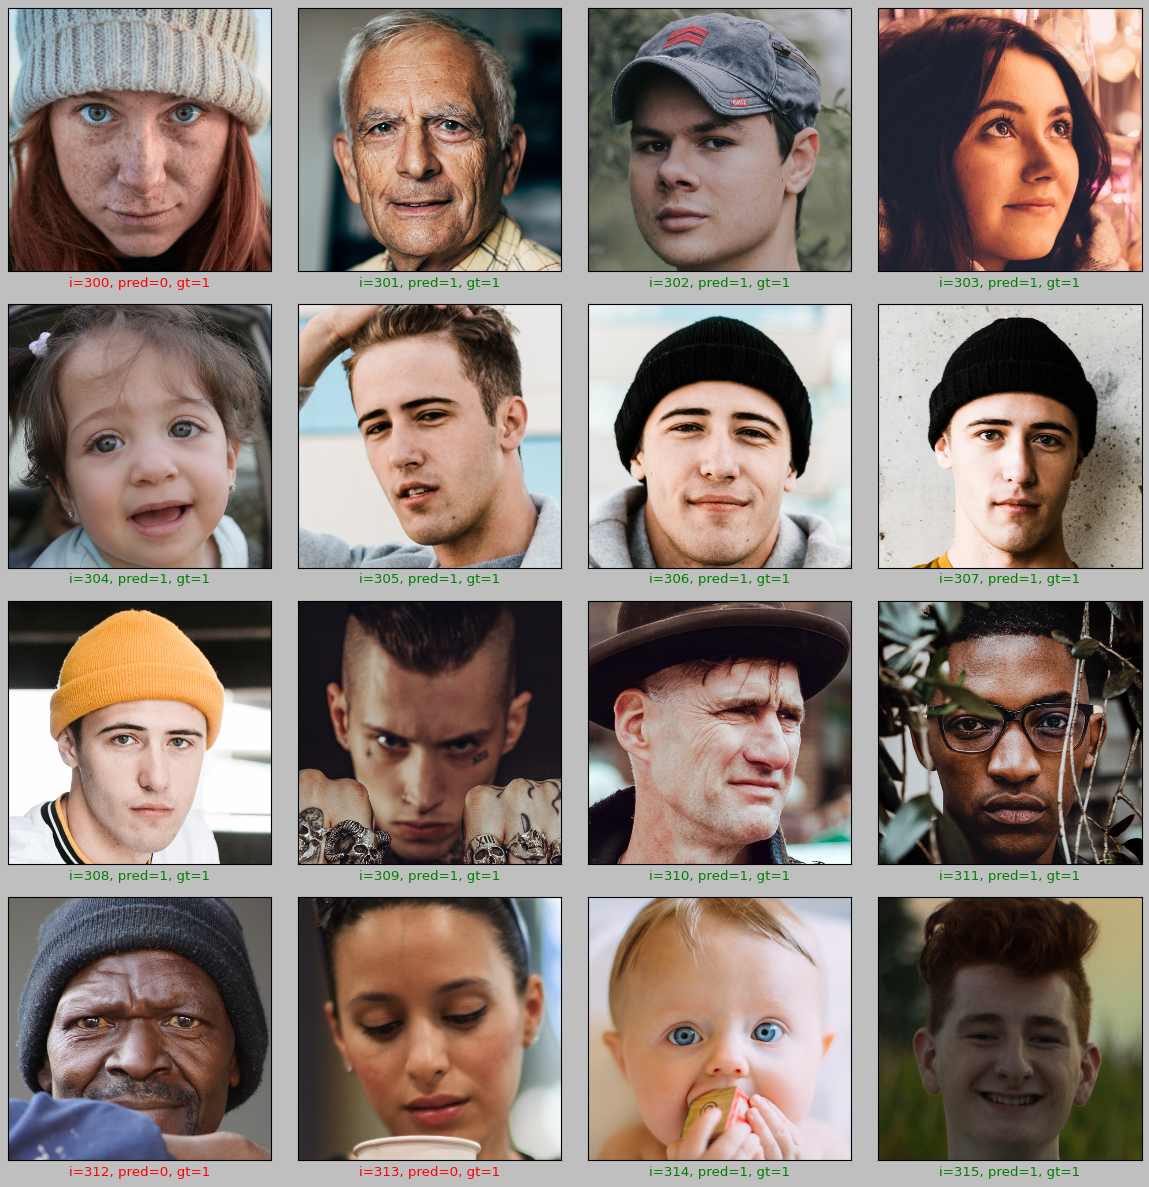

In [15]:
val_path = "./data/real_and_fake_face_detection/real_and_fake_face/"

plt.figure(figsize=(15, 15))
start_index = 300
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  preds = np.argmax(predictions[[start_index + i]])
  
  gt = val_generator.filenames[start_index + i][9:13]
  if gt == "fake":
    gt = 0
  else:
    gt = 1
    
  if preds != gt:
    col = "r"
  else:
    col = "g"
    
  plt.xlabel('i={}, pred={}, gt={}'.format(start_index+i, preds, gt), color=col)
  plt.imshow(load_img(val_path+val_generator.filenames[start_index + i]))
  plt.tight_layout()
  
plt.show()